# Download PlanetScope Images
#### Notebook Author: Justin Pflug
#### Edited by: Emma Boudreau
In this notebook you can download PlanetScope atmospherically corrected surface reflectance product (ortho_analytic_4b_sr). A DOMAIN_NAME.py file defining geometry_filter, date_range_filter, and cloud_cover_filter.


### Geometry (AOI) 
#### Specification: 
- EPSG: 4326
- No self-intersection
- <= 500 vertices
- Supports: polygon, multipolygon, multipoint, point, feature collection objects


#### AOI preparation options:
- Manual: [GEOJSON.io](https://geojson.io/#map=2/0/20) to create, [MapShaper.org](https://mapshaper.org) to simplify
- Python: [Planet developers blog on geometries](https://developers.planet.com/blog/2022/Dec/15/simplifying-your-complex-area-of-interest-a-planet-developers-deep-dive/)


In [1]:
import os
import requests
import geopandas as gpd
from requests.auth import HTTPBasicAuth
from shapely.geometry import shape
import numpy as np
import subprocess
import json
import pathlib
import pandas as pd
headers = {'Content-Type': 'application/json'}

############# SET THESE VARIABLES ######################
# redefined based on the filter you want to use

from geojson_DNBC_BS import domain 


domainID = 'DNBC_BS'
name = 'DNBC'

# enter the Planet user API key
apiKey = ' '
item_type = "PSScene"
asset_type = "ortho_analytic_4b_sr"
bundle_type = "analytic_sr_udm2"

# data download location
out_direc = ''
############# DON'T CHANGE VARIABLES BEYOND THIS ############

In [2]:
############ FUNCTIONS. DON'T CHANGE THESE!!! #########
def build_payload(item_ids, item_type, bundle_type, aoi_coordinates):
    payload = {
        "name": item_ids[0],
        "source_type": "scenes",
        "products": [
            {
                "item_ids": item_ids,
                "item_type": item_type,
                "product_bundle": bundle_type
            }
        ],
        "tools": [
            {
                "clip": {
                    "aoi": {
                        "type": "Polygon",
                        "coordinates": aoi_coordinates
                    }
                }
            }
        ]
    }
    return payload

def order_now(payload,apiKey):
    orders_url = 'https://api.planet.com/compute/ops/orders/v2'
    response = requests.post(orders_url, data=json.dumps(payload), auth=HTTPBasicAuth(apiKey, ''), headers=headers)
    print(response)

    if response.status_code==202:
        order_id =response.json()['id']
        url = f"https://api.planet.com/compute/ops/orders/v2/{order_id}"
        # feature_check = requests.get(url, auth=(PLANET_API_KEY, ""))
        feature_check = requests.get(url, auth=HTTPBasicAuth(apiKey, ''))
        if feature_check.status_code==200:
            print(f"Submitted a total of {len(feature_check.json()['products'][0]['item_ids'])} image ids: accepted a total of {len(feature_check.json()['products'][0]['item_ids'])} ids")
            print(f"Order URL: https://api.planet.com/compute/ops/orders/v2/{order_id}")
            return f"https://api.planet.com/compute/ops/orders/v2/{order_id}"
    else:
        print(f'Failed with Exception code : {response.status_code}')
        
def download_results(order_url,folder, overwrite=False):
    r = requests.get(order_url, auth=HTTPBasicAuth(apiKey, ''))
    try:
        if r.status_code ==200:
            response = r.json()
            results = response['_links']['results']
            results_urls = [r['location'] for r in results]
            results_names = [r['name'] for r in results]
            print('{} items to download'.format(len(results_urls)))

            for url, name in zip(results_urls, results_names):
                path = pathlib.Path(os.path.join(folder,name))

                if overwrite or not path.exists():
                    print('downloading {} to {}'.format(name, path))
                    r = requests.get(url, allow_redirects=True)
                    path.parent.mkdir(parents=True, exist_ok=True)
                    open(path, 'wb').write(r.content)
                else:
                    print('{} already exists, skipping {}'.format(path, name))
        else:
            print(f'Failed with response {r.status_code}')
    except:
        print('data not ready yet')
    r.close()
    # except Exception as e:
    #     print(e)
    #     print(order_url)
    #     raise Exception
    # r.close()

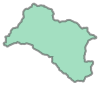

In [3]:
# ensure that the domain shape makes sense
domain_geometry = shape(domain['config'][0]['config'])
domain_geometry

In [10]:
# Search API request object
search_endpoint_request = {
  "item_types": [item_type],
  "filter": domain
}
result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(apiKey, ''),
    json=search_endpoint_request)

In [5]:
# view available data and prepare the list of planet IDs to download
geojson_data = result.json()
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Add a new column to 'gdf' with the intersection area
gdf['intersection_area'] = gdf['geometry'].intersection(domain_geometry).area

# Calculate the percentage overlap
gdf['overlap_percentage'] = (gdf['intersection_area'] / domain_geometry.area) * 100

gdf

,geometry,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,...,snow_ice_percent,strip_id,sun_azimuth,sun_elevation,updated,view_angle,visible_confidence_percent,visible_percent,intersection_area,overlap_percentage
0,"POLYGON ((-119.56043 38.03245, -119.59992 37.8...",2020-05-27T18:51:40.733663Z,0.00,91,83,0.00,0,True,3.7,0,...,17,3434245,135.4,68.5,2023-08-17T04:04:54Z,2.1,72,100,5.786334e-04,7.019851
1,"POLYGON ((-119.20241 37.90571, -119.16067 37.7...",2020-05-27T18:29:05.028028Z,0.00,97,99,0.00,0,True,4.0,0,...,1,3435440,125.5,65.4,2023-08-17T07:20:05Z,3.0,81,100,1.414571e-07,0.001716
2,"POLYGON ((-119.53190 38.01044, -119.57120 37.8...",2020-05-26T18:50:02.802693Z,0.00,91,76,0.00,0,True,3.8,0,...,24,3431367,135.8,68.5,2023-08-17T01:50:24Z,3.0,74,100,3.111332e-03,37.745985
3,"POLYGON ((-119.33295 37.84521, -119.31691 37.7...",2020-05-26T16:25:16.302534Z,0.02,88,60,0.00,0,True,3.5,0,...,40,3431325,94.7,42.1,2021-03-15T06:34:04Z,4.0,90,100,1.914864e-03,23.230700
4,"POLYGON ((-119.36160 37.96157, -119.34512 37.8...",2020-05-26T16:25:18.123387Z,0.00,86,67,0.00,0,True,3.5,0,...,33,3431325,94.7,42.1,2021-03-15T06:33:50Z,4.0,86,100,1.284251e-03,15.580246
5,"POLYGON ((-119.34717 37.90347, -119.33084 37.8...",2020-05-26T16:25:17.213223Z,0.01,90,77,0.00,0,True,3.5,0,...,23,3431325,94.7,42.1,2021-03-15T06:33:46Z,4.0,88,100,5.815643e-03,70.554067
6,"POLYGON ((-119.24141 37.92979, -119.26152 37.8...",2020-05-26T18:24:18.482796Z,0.07,87,80,0.02,2,True,3.9,0,...,19,3431276,124.1,64.5,2021-03-15T06:31:01Z,1.9,66,98,2.418739e-03,29.343595
7,"POLYGON ((-119.25858 37.86486, -119.27860 37.7...",2020-05-26T18:24:19.513021Z,0.25,81,65,0.00,0,True,3.9,0,...,34,3431276,123.9,64.5,2021-03-15T06:30:59Z,1.9,75,100,1.903738e-03,23.095722
8,"POLYGON ((-119.22157 37.82720, -119.24154 37.7...",2020-05-26T18:24:46.922772Z,0.19,78,69,0.00,0,True,3.9,0,...,31,3431552,124.3,64.8,2021-03-15T06:30:11Z,0.1,75,100,7.690832e-05,0.933034
9,"POLYGON ((-119.20386 37.89263, -119.22369 37.8...",2020-05-26T18:24:45.887304Z,0.08,86,88,0.00,0,True,3.9,0,...,12,3431552,124.5,64.8,2021-03-15T06:30:09Z,0.1,75,100,4.479224e-04,5.434093


In [6]:
# prep the ID and geometry lists
id_list = [feature['id'] for idx, feature in enumerate(geojson_data['features']) if gdf['overlap_percentage'].iloc[idx] >= 55]
geom_list = [feature['geometry'] for idx, feature in enumerate(geojson_data['features']) if gdf['overlap_percentage'].iloc[idx] >= 55]
print(len(id_list))
print(sorted(id_list))

6
['20200516_162655_0f2b', '20200520_182645_1018', '20200523_182403_1009', '20200524_162611_0f36', '20200524_182506_1039', '20200526_162517_0f2b']


In [ ]:
### ONLY RUN THIS CELL IF YOU WANT TO CHECK ON ORDER STATUS

# # see the status of the requested tiles. Are they "active"?
# for IDD in id_list:
#     print(IDD)
#     command = 'curl -L -H "Authorization: api-key '+apiKey+'"'
#     sublink = " 'https://api.planet.com/data/v1/item-types/"+item_type+"/items/"+IDD+"/assets/' "
#     # sublink = " 'https://api.planet.com/data/v2/item-types/"+item_type+"/items/"+IDD+"/assets/' "
#     command = command+sublink+'| jq .'+asset_type+'.status'
#     status = subprocess.run(command, shell=True)
#     print(command)
#     # break

In [7]:
# prepare and submit the orders
order_urls = pd.DataFrame(columns = ["index","ID_geom", "order_url"])

# loop through each order payload, and submit
for idx,IDD in enumerate(id_list):
    print(idx,IDD)
    
    payload = build_payload([IDD],item_type,bundle_type,domain['config'][0]['config']['coordinates'])
    order_url = order_now(payload,apiKey)
    
    order_urls.loc[idx, "index"] = idx        
    order_urls.loc[idx, "ID_geom"] = IDD
    order_urls.loc[idx, "order_url"] = order_url

0 20200526_162517_0f2b
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/9b222844-7c23-42ea-8330-29b5021a1598
1 20200524_162611_0f36
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/8cb68f34-4c55-4750-9442-684726154111
2 20200524_182506_1039
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/8e643199-5fc0-405b-accd-fc4c524cf6f6
3 20200523_182403_1009
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/c4745b76-15e1-4413-9b18-bca8237c92b2
4 20200520_182645_1018
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/f730f086-aa97-4866-9255-a2faa3db81ce
5 20200516_162655_0f2b
<Response [2

In [ ]:
# check out the data, save to a csv if you want to come back later
# print(order_urls)
# order_urls.to_csv('BUDD_urlSaver.csv', index = None)# save all URLs

In [8]:
# create or add to URL saver csv
url_saver = f'{name}_urlSaver.csv'

if not os.path.exists(url_saver):
    print(order_urls)
    order_urls.to_csv(url_saver, index=None)  # Save all URLs
else:
    # If downloading dates separately, save the order_urls to already created csv when running for the first time
    existing_urls = pd.read_csv(url_saver)
    updated_urls = pd.concat([existing_urls, order_urls], ignore_index=True)
    updated_urls.to_csv(url_saver, index=None)

In [4]:
order_urls = pd.read_csv(f'/home/etboud/projects/snow_mapping/planet/{name}_urlSaver.csv')

In [5]:
# download the orders once ready
# outputs of "data not ready yet" mean that the orders need more time to process before downloading
for url in order_urls.itertuples():
    print(url.index,url.order_url)
    print("start downloading data to".format(), out_direc + url.ID_geom)
    if url.order_url != None:
        try:
            nantest = ~np.isnan(url.order_url)
        except:
            download_results(url.order_url,folder = out_direc + url.ID_geom)
    # break

0 https://api.planet.com/compute/ops/orders/v2/d3dd2b6c-6ffc-46e0-8e0b-378b51c5417b
start downloading data to /home/etboud/projects/data/planet/DNBC/20230929_175207_64_2415
5 items to download
/home/etboud/projects/data/planet/DNBC/20230929_175207_64_2415/d3dd2b6c-6ffc-46e0-8e0b-378b51c5417b/PSScene/20230929_175207_64_2415_3B_AnalyticMS_metadata_clip.xml already exists, skipping d3dd2b6c-6ffc-46e0-8e0b-378b51c5417b/PSScene/20230929_175207_64_2415_3B_AnalyticMS_metadata_clip.xml
/home/etboud/projects/data/planet/DNBC/20230929_175207_64_2415/d3dd2b6c-6ffc-46e0-8e0b-378b51c5417b/PSScene/20230929_175207_64_2415_metadata.json already exists, skipping d3dd2b6c-6ffc-46e0-8e0b-378b51c5417b/PSScene/20230929_175207_64_2415_metadata.json
/home/etboud/projects/data/planet/DNBC/20230929_175207_64_2415/d3dd2b6c-6ffc-46e0-8e0b-378b51c5417b/PSScene/20230929_175207_64_2415_3B_udm2_clip.tif already exists, skipping d3dd2b6c-6ffc-46e0-8e0b-378b51c5417b/PSScene/20230929_175207_64_2415_3B_udm2_clip.tif
/ho